<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab13_MCMC_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import quad, cumulative_trapezoid, cumulative_simpson
from scipy.stats import gaussian_kde
from statsmodels.graphics.tsaplots import plot_acf

# Lab 13: Markov Chain Monte Carlo (SOLUTIONS)

This is the end of the semester, so the lab has less "hand-holding" than before!

Lab created by Stephen Becker, Nov 2024 for SciML class at University of Colorado Boulder

## Part 1: Metropolis algorithm
You're given the function `q` below which is proportional to a probability `p` that we'd like to sample from.  
- Code a **Metropolis** sampling algorithm
- Pick a jump function (to propose new samples)
- Run the code using your jump function and the provided `q` sampling function, and generate a lot of samples
- Plot a histogram of these samples and make some comments

## Part 2: nicer results
- We plotted the histogram before, but this has a resolution problem -- if we have a lot of bins, each bin has poor statistics; but if we have a few bins, we don't have much resolution.
- To supplement the histogram, plot a kernel density estimate of the MCMC samples. This also has a bias-accuracy tradeoff (due to the bandwidth selection), but it still gives some nice information that you don't get just from a histogram

## Part 3: independence
- Are the samples from our MCMC sampler independent? Do some computation to support your answer
  - I suggest looking at the autocorrelation function (ACF)
  - It's generally not possible to prove that samples **are** independent, but we can be quite certain sometimes that various samples are **not** independent.  In particular, independent samples are uncorrelated (though not necessarily vice-versa), so if you find correlations that you believe are not spurious, then the samples cannot be independent


## Part 4: if you have time...
- Numerically integrate $q$ using `scipy.integrate.cumulative_simpson` to get the CDF and then do [inverse CDF sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling). This is only really practical in 1D.
  - [`np.interp`](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) may be helpful
  - Plot a histogram of your samples using the inverse CDF sampling

- you could record how many failed steps are in the Metropolis algorithm, since that affects how efficient it is
- you could also explore the effect of different jump functions on the quality of your Metropolis algorithm

## Helpful references
- on [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
  - Ch. 14 of Christopher Bishop's [Deep Learning](https://link.springer.com/book/10.1007/978-3-031-45468-4) (free PDF via SpringerLink)
  - Lecture notes on [ch 15 Sampling Methds](https://www.ece.virginia.edu/~ffh8x/docs/teaching/esl/15-Sampling-Methods.pdf) by Farzad Farnoud (U. of Virginia), part of [Statistical Learning and Graphical Models](https://www.ece.virginia.edu/~ffh8x/esl.html) class taught 2021 (see ch 5 [Linear Regression](https://www.ece.virginia.edu/~ffh8x/docs/teaching/esl/05-Linear-Regression.pdf) for "Bayesian Linear Regression" and an example of a non-informative prior that sets up a case where one has an unnormalized pdf).
  - Another set of lectures notes, these by Eric Xing at CMU, scribed 2014, [Approximate Inference: Markov Chain Monte Carlo](https://www.cs.cmu.edu/~epxing/Class/10708-14/scribe_notes/scribe_note_lecture17.pdf)
  - We're doing the "Metropolis" algorithm which uses a symmetric jump function, and can be seen as a special case of (the better-known) [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm
  - For efficient, state-of-the-art MCMC with all the bells-and-whistles, in an interface that prevents you from making silly mistakes, try [PyMC](https://www.pymc.io/welcome.html). However, that's overkill for this lab, as we want to explore the very basics and get our hands dirty.
- Documentation for functions
  - use [`scipy.stats.gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html) for the [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)
  - use [`scipy.integrate.quad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) for numerical integration (quadrature)
  - use [`statsmodels.graphics.tsaplots.plot_acf`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) to plot the [ACF](https://en.wikipedia.org/wiki/Autocorrelation)

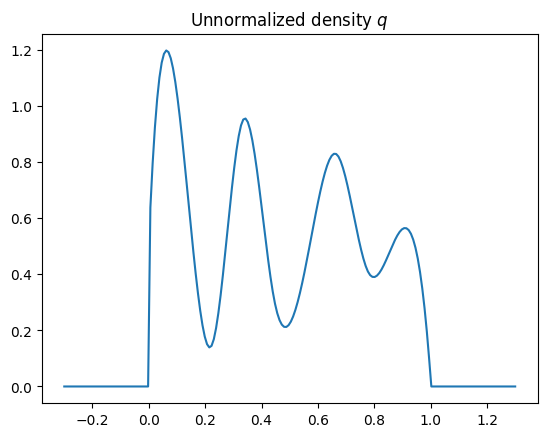

In [2]:
# Pick an arbitrary, simple 1D function q
#   (that has some wiggles to it, to make it interesting)
# We'll have it supported on [0,1]. In case the sampler proposes an estimate
#   x that is outside the support, we just say that this proposal has 0 probability,
#   i.e., we just define q(x) = 0 if x is outside of [0,1]
rng = np.random.default_rng(1)

def out_of_bounds(f,a=0,b=1):
    """ this limits a function to a domain (a,b) [i.e., zero outside] """
    def g(x):
        """ input x might be vectorized """
        out = f(x)
        out[ x < a ] = 0
        out[ x > b ] = 0
        return out
    return g

# We pick a few points and interpolate between them with a cubic spline to give us
#   an interesting (but smooth) function q(x)
q = out_of_bounds( CubicSpline( np.linspace(0,1,num=10), rng.uniform(0,1,size=10) ) )

xgrid = np.linspace(-.3,1.3,num=200)
ygrid = q(xgrid)
plt.plot(xgrid,ygrid)
plt.title('Unnormalized density $q$')
plt.show()

## Part 1

Implement Metropolis MCMC

Without doing anything fancy (and no jax/jit), it takes about 3 seconds to generate 100,000 samples

In [5]:
%%time
rng = np.random.default_rng(1) # if we want it to be reproducible... not necessary

def Metropolis(q, jump, theta0, n, rng = np.random.default_rng(), burn_in = -1 ):
    """ 1D Metropolis sampler
    The burn-in period is in case our initial guess is an unlucky guess that
    happens to be in a region of very low probability.
    """
    theta_list = np.zeros(n)
    theta = theta0
    U     = rng.uniform(0,1,size=n)
    for k in range(n):
        theta_proposed = jump(theta)
        if U[k] < q(theta_proposed)/q(theta):
            theta = theta_proposed
        theta_list[k] = theta

    if burn_in < 0 : burn_in = round(n/10)

    theta_list = theta_list[burn_in:]
    return theta_list

# Pick a "jump" transition. No need to get fancy, we can just define
#   q(theta|theta_old) = theta_old + sigma*N(0,1)
#   This is symmetric in theta and theta_old since N(0,1) is symmetric,
#   so we can use it for Metropolis (otherwise we'd use Metropolist-Hastings)
def jump(theta_old):
    return rng.normal(theta_old, .1)


# and collect samples
n       = int(1e5)
samples = Metropolis(q,jump,.5,n, rng)

CPU times: user 2.51 s, sys: 5.27 ms, total: 2.52 s
Wall time: 3.21 s


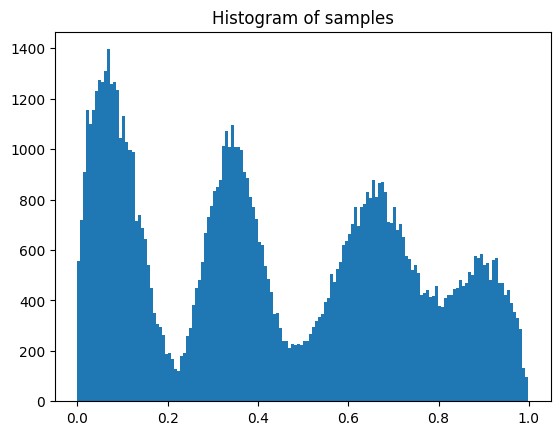

In [42]:
plt.hist(samples,bins=150)
plt.title('Histogram of samples')
plt.show()

## Part 2: nicer plots using KDE

Notice that the MCMC estimate under-estimates the peaks and over-estimates the troughs. This *could* be from the MCMC samples themselves, but it's more likely an artifact of the KDE smoothing

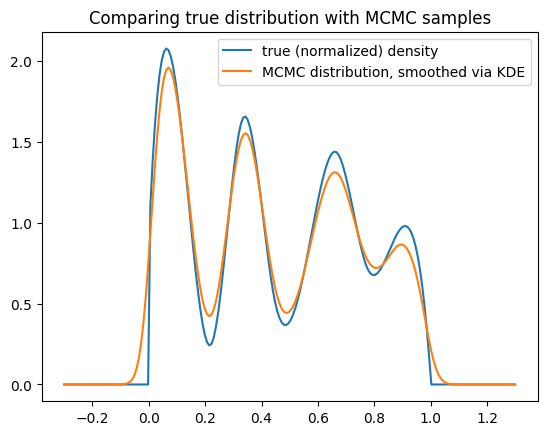

In [43]:
# KDE
kernel = gaussian_kde(samples)

# There's a scaling factor difference (since original q was unnormalized)
Z = quad(q,0,1)[0]

xgrid = np.linspace(0,1,num=200)
plt.plot(xgrid,q(xgrid)/Z, label='true (normalized) density') # divide by Z to normalize
plt.plot(xgrid,kernel(xgrid), label='MCMC distribution, smoothed via KDE')
plt.legend()
plt.title('Comparing true distribution with MCMC samples')
plt.show()

## Part 3: But what if wanted independent samples?
We can't every guarantee that, but we can at least not be as highly correlated as the naive output

Below is the ACF, which shows that consecutive samples **are** definitely correlated. In fact, samples until about ~100 apart are correlated (this value is not precise, it's based loosely on when the ACF values go below the little 95% error bar that the `plot_acf` shows).  The value for your code will depend on your jump function (in our case, using a Gaussian, it depends on the value of $\sigma$ that we chose for it)




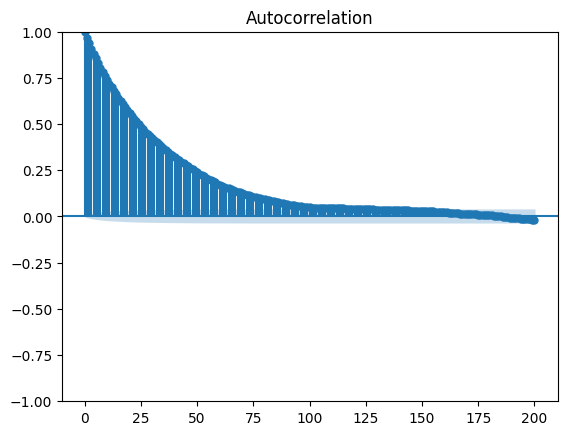

In [44]:
# Look at autocorrelation
plot_acf(samples,lags=200)
plt.title('Autocorrelation')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

Our simplest fix is just to subsample...

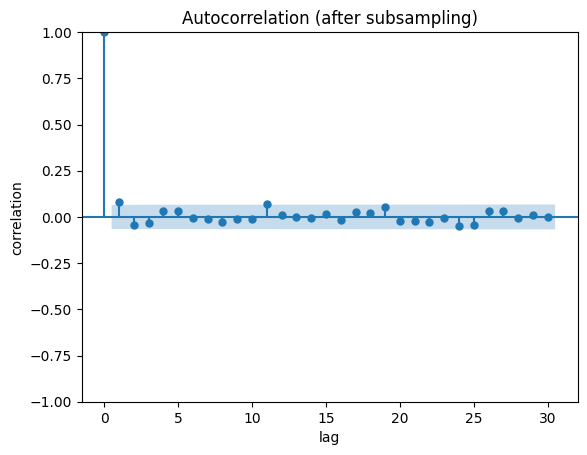

In [6]:
# Look at autocorrelation
plot_acf(samples[::100])
plt.title('Autocorrelation (after subsampling)')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

... that looks better. Note that we always have a correlation of 1 at lag 0 (by definition of ACF), so that's nothing to be alarmed about

## Part 4: going farther

Try inverse CDF sampling

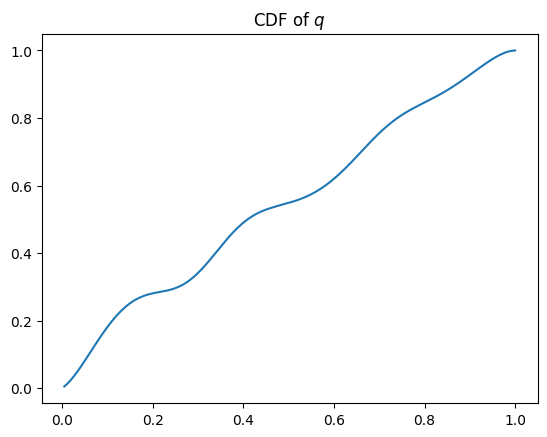

In [7]:
# First, compute the CDF. We can't compute it exactly, but we'll discretize and then sum.
#   We really want to integrate, so our "sum" wil be via a quadrature rule
#   The "cumulative_..." quadrature rules do exactly what we want
xgrid = np.linspace(0,1,num=200)
y     = q(xgrid)
cdf   = cumulative_simpson(y,x=xgrid)
cdf   = cdf/cdf[-1]

plt.plot(xgrid[1:],cdf)
plt.title('CDF of $q$')
plt.show()

In [8]:
def inverseCDF(cdf, xgrid, n = int(1e4), rng = np.random.default_rng() ):
    y = rng.uniform(low=0.0,high=1.0,size=n )
    y = np.interp(y,cdf,xgrid[1:])
    return y

samples = inverseCDF(cdf,xgrid, n = int(1e5) )

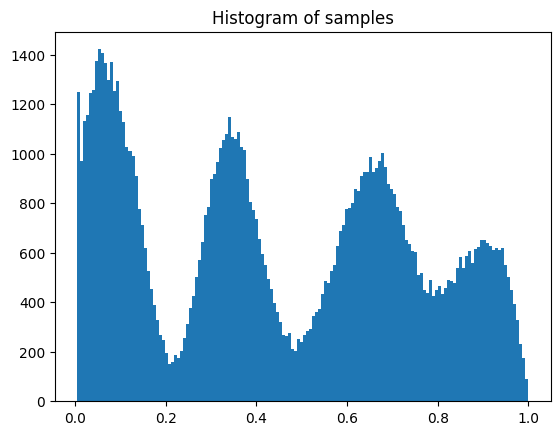

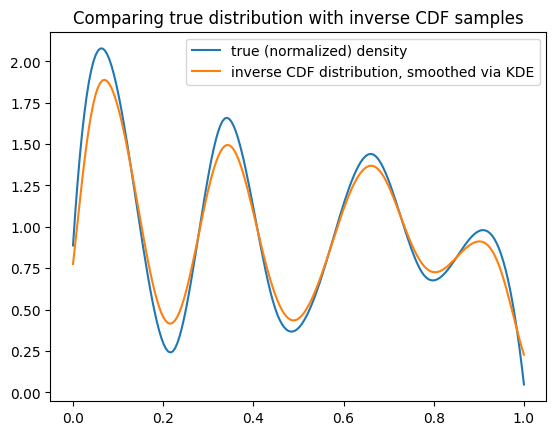

In [9]:
plt.hist(samples,bins=150)
plt.title('Histogram of samples')
plt.show()

kernel = gaussian_kde(samples)

# There's a scaling factor difference (since original q was unnormalized)
Z = quad(q,0,1)[0]

xgrid = np.linspace(0,1,num=200)
plt.plot(xgrid,q(xgrid)/Z, label='true (normalized) density') # divide by Z to normalize
plt.plot(xgrid,kernel(xgrid), label='inverse CDF distribution, smoothed via KDE')
plt.legend()
plt.title('Comparing true distribution with inverse CDF samples')
plt.show()